In [6]:
#https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_original = fetch_ucirepo(id=15) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_original.data.features 
y = breast_cancer_wisconsin_original.data.targets 
  
# metadata 
print(breast_cancer_wisconsin_original.metadata) 
  
# variable information 
print(breast_cancer_wisconsin_original.variables) 

{'uci_id': 15, 'name': 'Breast Cancer Wisconsin (Original)', 'repository_url': 'https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original', 'data_url': 'https://archive.ics.uci.edu/static/public/15/data.csv', 'abstract': 'Original Wisconsin Breast Cancer Database', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 699, 'num_features': 9, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Class'], 'index_col': ['Sample_code_number'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1990, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C5HP4Z', 'creators': ['WIlliam Wolberg'], 'intro_paper': None, 'additional_info': {'summary': "Samples arrive periodically as Dr. Wolberg reports his clinical cases. The database therefore reflects this chronological grouping of the data. This grouping information appears immediately below, having been removed fro

In [7]:
from imblearn.pipeline import Pipeline
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#https://stackoverflow.com/questions/65250377/how-do-i-import-umap-package-in-python
import umap.umap_ as umap

#https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

def pipeline(dimension_reduction, classifier, features, target, dataset):
    
    #Data preprocessing
    dataset.drop_duplicates()
    
    #Impute missing values with column mean
    columns_ = dataset.columns
    imputer = SimpleImputer(strategy="mean")
    dataset = imputer.fit_transform(dataset)
    dataset = pd.DataFrame(dataset, columns = columns_)

    X = dataset[features]
    y = dataset[target]
    
    y_enc = OrdinalEncoder(categories = [np.unique(y).tolist()])
    y = y_enc.fit_transform(y.to_numpy().reshape(-1, 1))

    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
    print("\nFeatures to drop due to high correlation:", to_drop)
    X.drop(columns=to_drop, inplace=True, errors='ignore')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    dimension_reductions = {
        'pca': PCA(n_components = 2),
        'umap': umap.UMAP(n_components = 2)
        #'tsne': TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    }

    classifiers = {
        "svm": SVC(kernel="linear", probability=True, random_state=42),
        "logistic_regression": LogisticRegression(max_iter=1000, random_state=42),
        "random_forest": RandomForestClassifier(n_estimators=100, random_state=42)
    }

    pipe = Pipeline([('scaler', StandardScaler()),
                     (dimension_reduction, dimension_reductions[dimension_reduction]),
                     (classifier, classifiers[classifier])])
    
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

    scores = cross_validate(
        pipe, X_train, y_train,
        cv = cv,
        scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
        n_jobs=-1, verbose=1
    )

    print("5‑Fold CV performance (mean across folds): ")
    display(pd.DataFrame(scores).mean().round(4))

    pipe.fit(X_train, y_train)
    print("Before Hyperparameter tuning: \n", classification_report(y_test, pipe.predict(X_test)))
    print("ROC_AUC score: ", roc_auc_score(y_test, pipe.predict(X_test)))

    #Hyperparamter tuning

    #https://www.datacamp.com/tutorial/random-forests-classifier-python

    # RF
    rf_param_dist = {'random_forest__max_depth': [5, 15, 25],
                 'random_forest__n_estimators': [100, 250, 500],
                 'random_forest__class_weight': ["balanced", "balanced_subsample"],
                 'random_forest__min_samples_split': [2, 5, 10]}

    # SVM
    # Note the change in keys: 'svm__<param_name>'
    svm_param_dist = {'svm__C': [0.1, 1, 10],
                    'svm__gamma': ['scale', 'auto', 0.1, 1],
                    'svm__kernel': ['rbf', 'linear']} # Note: PCA often works best with linear kernels, but keep rbf for demonstration

    # LR
    # Note the change in keys: 'logistic_regression__<param_name>'
    lr_param_dist = {'logistic_regression__C': [0.001, 0.01, 0.1, 1, 10, 100],
                    'logistic_regression__penalty': ['l1', 'l2'],
                    'logistic_regression__solver': ['liblinear']} # liblinear supports l1 and l2

    parameters = {
        "svm": svm_param_dist,
        "logistic_regression": lr_param_dist,
        "random_forest": rf_param_dist
    }

    tuning = RandomizedSearchCV(pipe, param_distributions = parameters[classifier], n_iter = 3, cv = 3)
    tuning.fit(X_train, y_train)

    best_params = tuning.best_estimator_

    print("Best paramaters: ", best_params)

    tuned_pipe = Pipeline([('scaler', StandardScaler()),
                     (dimension_reduction, dimension_reductions[dimension_reduction]),
                     (classifier, best_params)])

    tuned_pipe.fit(X_train, y_train)
    print("After Hyperparameter tuning: \n", classification_report(y_test, tuned_pipe.predict(X_test)))
    print("ROC_AUC score: ", roc_auc_score(y_test, tuned_pipe.predict(X_test)))

    cm = confusion_matrix(y_test, tuned_pipe.predict(X_test), labels = tuned_pipe.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels = tuned_pipe.classes_)
    disp.plot()
    plt.show()

    return tuned_pipe


Features to drop due to high correlation: ['Uniformity_of_cell_shape']
5‑Fold CV performance (mean across folds): 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/rithikad/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/rithikad/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/rithikad/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/rithikad/Library/Python/3.9/lib/python/site-packages/sklearn/

fit_time          0.0669
score_time        0.0107
test_accuracy     0.9553
test_precision    0.9336
test_recall       0.9381
test_f1           0.9350
test_roc_auc      0.9916
dtype: float64

Before Hyperparameter tuning: 
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98        92
         1.0       0.94      0.98      0.96        48

    accuracy                           0.97       140
   macro avg       0.96      0.97      0.97       140
weighted avg       0.97      0.97      0.97       140

ROC_AUC score:  0.9732789855072462
Best paramaters:  Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('random_forest',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=25, min_samples_split=10,
                                        random_state=42))])
After Hyperparameter tuning: 
               precision    recall  f1-score   support

         0.0       0.99      0.96      0.97        92
         1.0       0.92      0.98      0.95        48

    accuracy                           0.96       140
   macro avg      

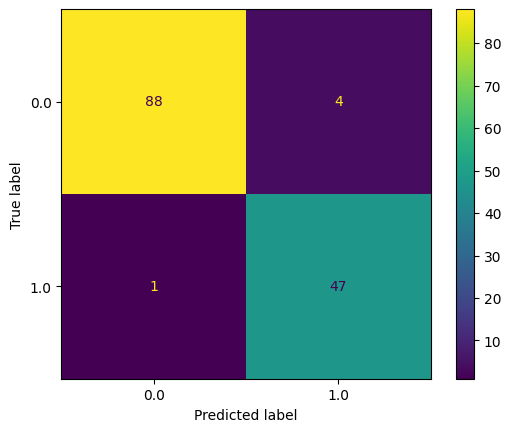

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('random_forest',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('pca', PCA(n_components=2)),
                                 ('random_forest',
                                  RandomForestClassifier(class_weight='balanced_subsample',
                                                         max_depth=25,
                                                         min_samples_split=10,
                                                         random_state=42))]))])

In [ ]:
df = pd.concat([X, y], axis=1)

pipeline('pca', 'random_forest', X.columns.to_list(), y.columns.to_list(), df)